In [149]:
import math
import json
import os
import random
from IPython import display
import sympy as sp
import numpy as np
import pandas as pd
import sklearn

pd.set_option('display.max_rows', None)


%run config.py

Utility functions

In [150]:
# Colors for terminal output
GREEN = "\033[92m"
RED = "\033[91m"
YELLOW = "\033[93m"
BLUE = "\033[94m"
CYAN = "\033[96m"
MAGENTA = "\033[95m"
BOLD = "\033[1m"
UNDERLINE = "\033[4m"
STANDARD = "\033[0m"

In [151]:
# Sequencer and Desequencer
def csv2sequence(csvFile,seqFile,pref):
	with open(csvFile, 'r') as f:
		lines = f.readlines()
		with open(seqFile, 'w') as g:
			for line in lines:
				for token in line.split(','):
					if token.startswith(pref):
						token = token[len(pref):]
					token = token.strip()
					if token!="" and token!='\n':
						g.write(token+'\n')

def sequence2csv(seqFile,csvFile,dataWidth,pref):
	with open(seqFile, 'r') as f:
		lines = f.readlines()
		dataW = dataWidth
		with open(csvFile, 'w') as g:
			for line in lines:
				g.write(pref+line.strip())
				dataW -= 1
				if dataW==0:
					g.write('\n')
					dataW = dataWidth
				else:
					g.write(',')

In [152]:
# Function to show the generated function
def showFunction():
	exec(open("generated.py").read())
	import IPython.display as disp
	disp.display(spExpr)
# showFunction()

In [153]:
# Function to show the generated BM
def showBM():
	display.Image("bondmachine.png")

In [154]:
def highlightDone(val):
    color = 'green' if val > 0.0 else 'red'
    return f'background-color: {color}'

environment creation functions

In [155]:
# Function create an environment with a random mathematical expression
def generateRandom():
	! echo "SOURCE_FLEXPY=generated.py" > source.mk
	! make clean > /dev/null
	! echo "SOURCE_FLEXPY=generated.py" > source.mk
	! flexpytester --generate -e symbols -s generated.py -i inputs.csv -o outputs.csv --prefix --config decayFactor=3 > /dev/null
	! bmhelper apply > /dev/null 
	! make show > /dev/null
	csv2sequence('inputs.csv','inputs.seq',"0f")
	csv2sequence('outputs.csv','outputs.seq',"0f")
# generateRandom()

In [156]:
# Function to generate the test cases of an existing mathematical expression
def generateExistent(functionFile):
	! echo "SOURCE_FLEXPY=generated.py" > source.mk
	! make clean > /dev/null
	! echo "SOURCE_FLEXPY=generated.py" > source.mk
	! flexpytester --compute -e generated.py -i inputs.csv -o outputs.csv --prefix > /dev/null 2>&1
	! bmhelper apply > /dev/null 2>&1
	! make show > /dev/null 2>&1
	csv2sequence('inputs.csv','inputs.seq',"0f")
	csv2sequence('outputs.csv','outputs.seq',"0f")
# generateExistent()

In [157]:
# Function to generate the test cases of an existing single neuron within the library
def generateNeuron(library, neuron, seq, benchcore):
	! echo "SOURCE_BASM=out.basm" > source.mk
	! make clean > /dev/null
	! echo "SOURCE_BASM=out.basm" > source.mk
	! rm -f notok
	if benchcore:
		! echo "BENCHCOREV2_FILE=sicv2" >> source.mk
		! echo "SIMBATCH_ARGS+=-b" >> source.mk
		! fragtester -neuron-lib-path {library} -fragment-file {neuron}.basm -save-expression generated.py -seq {seq} -create-bmapi bmapi.json -build-app -app-flavor cpynqapibenchv2 -app-file expression.c -sicv2-endpoints sicv2 || touch notok > /dev/null
	else:
		! fragtester -neuron-lib-path {library} -fragment-file {neuron}.basm -save-expression generated.py -seq {seq} -create-bmapi bmapi.json -build-app -app-flavor cpynqapi -app-file expression.c || touch notok > /dev/null
	if os.path.exists("notok"):
		return False
	! flexpytester --compute -e generated.py -i inputs.csv -o outputs.csv --prefix > /dev/null 2>&1
	! bmhelper apply > /dev/null 2>&1
	! make hdl > /dev/null 2>&1
	! make show > /dev/null 2>&1
	csv2sequence('inputs.csv','inputs.seq',"0f")
	csv2sequence('outputs.csv','outputs.seq',"0f")
	return True
# generateNeuron("library", "cosargreal", "0")

In [158]:
# Function to generate the test cases of an existing single neuron within the library
def getNeuronSeq(library, neuron):
	! rm -f notok
	! fragtester -neuron-lib-path {library} -fragment-file {neuron}.basm -save-expression generated.py  || touch notok > /dev/null
	if os.path.exists("notok"):
		return "0"
	! fragtester -neuron-lib-path {library} -fragment-file {neuron}.basm -save-expression generated.py -describe | grep "Sequences" | cut -d' ' -f2 > seqs.txt
	seq=1
	with open("seqs.txt", "r") as f:
		lines = f.readlines()
		for line in lines:
			seq=line.strip()
			return seq

In [159]:
# Function to generate the test cases of an existing single neuron within the library
def placeHolderNeuron(library, neuron):
	! echo "{" > statistics.json
	! echo -n "\"" >> statistics.json
	! echo -n {neuron} >> statistics.json
	! echo "\": 0" >> statistics.json
	! echo "}" >> statistics.json

 Simulation beckends

In [160]:
# BondMachine internal simulator
def runSimbatch():
	! make simbatch > /dev/null
# runSimbatch()

In [161]:
# BondMachine hardware run
def runBMsim():
	! make deploycollect > /dev/null
	! mv working_dir/bmsim_outputs.seq bmsim_outputs.seq
	! bondmachine -bondmachine-file working_dir/bondmachine.json -list-outputs | wc -l > num_outputs.txt
	# Read the number of outputs
	with open('num_outputs.txt','r') as f:
		num_outputs = int(f.read())
	sequence2csv('bmsim_outputs.seq','bmsim_outputs.csv',num_outputs,"")
# runBMsim()

In [162]:
# HLS simulator
def runHLSsim():
	print ("hlsim")
# runHLSsim()

Analysis

In [163]:
def analyzeSimbatch():
	# Load the target outputs from the output.csv file
	targetData = np.loadtxt('outputs.csv', delimiter=',')
	simbatchData = np.loadtxt('simbatch_outputs.csv', delimiter=',')
	latency = False

	if benchcore:
		benchcoreData = simbatchData[:, -1]
		# Move the last column,if there is a benchcore
		simbatchData = np.delete(simbatchData, -1, axis=1)

	simbatchMSE=sklearn.metrics.mean_squared_error(targetData, simbatchData)

	if benchcore:
		latency = benchcoreData.mean()
		data = {
			"Dataset": ["Sympy target", "Simbatch","Latency"],
			"MSE" : [0.0, simbatchMSE, latency]
		}
	else:
		data = {
			"Dataset": ["Sympy target", "Simbatch"],
			"MSE" : [0.0, simbatchMSE]
		}
	df = pd.DataFrame(data)
	return df.style.hide(axis="index"), simbatchMSE, latency

	

In [164]:
def analyzeBMsim():
	# Load the target outputs from the output.csv file
	targetData = np.loadtxt('outputs.csv', delimiter=',')
	bmsimData = np.loadtxt('bmsim_outputs.csv', delimiter=',')
	latency = False

	if benchcore:
		benchcoreData = bmsimData[:, -1]
		# Move the last column,if there is a benchcore
		bmsimData = np.delete(bmsimData, -1, axis=1)

	bmsimMSE=sklearn.metrics.mean_squared_error(targetData, bmsimData)

	if benchcore:
		latency = benchcoreData.mean()
		data = {
			"Dataset": ["Sympy target", "BMsim","Latency"],
			"MSE" : [0.0, bmsimMSE, latency]
		}
	else:
		data = {
			"Dataset": ["Sympy target", "BMsim"],
			"MSE" : [0.0, bmsimMSE]
		}
	df = pd.DataFrame(data)
	return df.style.hide(axis="index"), bmsimMSE, latency

Statistics management functions

In [165]:
def plotHistogram(df):
	# Plot the histogram
	df['bsimoccurrences'].plot(kind='bar', figsize=(10, 6), color='skyblue')


In [166]:
def loadBsimRun(mse,latency):
	with open('statistics.json', 'r') as f:
		data = json.load(f)
	
	df = pd.DataFrame.from_dict(data, orient='index', columns=['bsimoccurrences'])
	totOccurrences = df['bsimoccurrences'].sum()
	newCol=mse
	if totOccurrences > 0:
		newCol = newCol/totOccurrences
		df['bsimerror'] = newCol
	else:
		df['bsimerror'] = 0.0
	if latency:
		df['bsimlatency'] = latency
	
	return df

In [167]:
def loadBMsimRun(mse,latency):
	with open('statistics.json', 'r') as f:
		data = json.load(f)
	
	df = pd.DataFrame.from_dict(data, orient='index', columns=['bmoccurrences'])
	totOccurrences = df['bmoccurrences'].sum()
	newCol=mse
	if totOccurrences > 0:
		newCol = newCol/totOccurrences
		df['bmerror'] = newCol
	else:
		df['bmerror'] = 0.0
	if latency:
		df['bmlatency'] = latency
	return df

In [168]:
def PatchBsimGlobalStats(global_stats, df):
	# If the global statistics DataFrame is empty, initialize it with the same rows as the current DataFrame
	for index, row in df.iterrows():
		if index not in global_stats.index:
			global_stats.loc[index] = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

	# Sum the occurrences to the global statistics
	for index, row in df.iterrows():
		if row['bsimoccurrences'] > 0:
			firstRun=False
			if global_stats.at[index, 'bsimoccurrences'] == 0:
				firstRun=True
			sumErrors=global_stats.at[index, 'bsimoccurrences'] * global_stats.at[index, 'bsimerror'] + row['bsimerror']
			if 'bsimlatency' in row and (global_stats.at[index, 'bsimlatency']>0.0 or firstRun):
				sumLatencies=global_stats.at[index, 'bsimoccurrences'] * global_stats.at[index, 'bsimlatency'] + row['bsimlatency']
			global_stats.at[index, 'bsimoccurrences'] += row['bsimoccurrences']
			global_stats.at[index, 'bsimerror'] = sumErrors / global_stats.at[index, 'bsimoccurrences']
			if 'bsimlatency' in row and (global_stats.at[index, 'bsimlatency']>0.0 or firstRun):
				global_stats.at[index, 'bsimlatency'] = sumLatencies / global_stats.at[index, 'bsimoccurrences']

	# Save the updated global statistics
	global_stats.to_csv('global_statistics')
	return global_stats


In [169]:
def PatchBMsimGlobalStats(global_stats, df):
	# If the global statistics DataFrame is empty, initialize it with the same rows as the current DataFrame
	for index, row in df.iterrows():
		if index not in global_stats.index:
			global_stats.loc[index] = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

	# Sum the occurrences to the global statistics
	for index, row in df.iterrows():
		if row['bmoccurrences'] > 0:
			firstRun=False
			if global_stats.at[index, 'bmoccurrences'] == 0:
				firstRun=True
			sumErrors=global_stats.at[index, 'bmoccurrences'] * global_stats.at[index, 'bmerror'] + row['bmerror']
			if 'bmlatency' in row and (global_stats.at[index, 'bmlatency']>0.0 or firstRun):
				sumLatencies=global_stats.at[index, 'bmoccurrences'] * global_stats.at[index, 'bmlatency'] + row['bmlatency']
			global_stats.at[index, 'bmoccurrences'] += row['bmoccurrences']
			global_stats.at[index, 'bmerror'] = sumErrors / global_stats.at[index, 'bmoccurrences']
			if 'bmlatency' in row and (global_stats.at[index, 'bmlatency']>0.0 or firstRun):
				global_stats.at[index, 'bmlatency'] = sumLatencies / global_stats.at[index, 'bmoccurrences']

	# Save the updated global statistics
	global_stats.to_csv('global_statistics')
	return global_stats


In [170]:
def loadGlobalStats():
	# Load the global statistics from the CSV file if it exists
	if os.path.exists('global_statistics'):
		global_stats = pd.read_csv('global_statistics', index_col=0)
		global_stats.sort_index(inplace=True)
	else:
		# Create an empty DataFrame with the same columns as the global statistics
		global_stats = pd.DataFrame(columns=['bsimoccurrences', 'bsimerror', 'bmoccurrences', 'bmerror','bmlatency', 'bsimlatency'])
	return global_stats

In [171]:
def latencyHistogram(dataFile, latencyCol, title):
	df = pd.read_csv(dataFile)
	df.columns = ['error', latencyCol]
	import matplotlib.pyplot as plt

	plt.figure(figsize=(10, 6))
	plt.hist(df[latencyCol], bins=30, color='skyblue', edgecolor='black')
	plt.title(title)
	plt.xlabel('Latency')
	plt.ylabel('Frequency')
	plt.grid(True)
	plt.show()
	return plt.gcf()

In [172]:
def compareLatencyDistributions(bsimData, bmsimData):
	"""
	Compare two latency distributions using statistical tests and visualizations.
	
	Args:
		bsimData: pandas Series of Simbatch latencies
		bmsimData: pandas Series of BMsim latencies
	
	Returns:
		Dictionary with comparison results
	"""
	from scipy import stats
	import matplotlib.pyplot as plt
	
	results = {}
	
	# 1. Descriptive Statistics
	results['bsim_stats'] = {
		'mean': bsimData.mean(),
		'median': bsimData.median(),
		'std': bsimData.std(),
		'min': bsimData.min(),
		'max': bsimData.max(),
		'q25': bsimData.quantile(0.25),
		'q75': bsimData.quantile(0.75)
	}
	
	results['bmsim_stats'] = {
		'mean': bmsimData.mean(),
		'median': bmsimData.median(),
		'std': bmsimData.std(),
		'min': bmsimData.min(),
		'max': bmsimData.max(),
		'q25': bmsimData.quantile(0.25),
		'q75': bmsimData.quantile(0.75)
	}
	
	# 2. Statistical Tests
	# Kolmogorov-Smirnov Test (are distributions different?)
	ks_stat, ks_pvalue = stats.ks_2samp(bsimData, bmsimData)
	results['ks_test'] = {
		'statistic': ks_stat,
		'p_value': ks_pvalue,
		'significant': ks_pvalue < 0.05
	}
	
	# Mann-Whitney U Test (non-parametric comparison of medians)
	mw_stat, mw_pvalue = stats.mannwhitneyu(bsimData, bmsimData, alternative='two-sided')
	results['mann_whitney'] = {
		'statistic': mw_stat,
		'p_value': mw_pvalue,
		'significant': mw_pvalue < 0.05
	}
	
	# Wasserstein Distance (Earth Mover's Distance)
	wasserstein = stats.wasserstein_distance(bsimData, bmsimData)
	results['wasserstein_distance'] = wasserstein
	
	# 3. Visualizations
	fig, axes = plt.subplots(2, 2, figsize=(14, 10))
	
	# Overlaid histograms
	axes[0, 0].hist(bsimData, bins=30, alpha=0.5, label='Simbatch', color='blue', edgecolor='black')
	axes[0, 0].hist(bmsimData, bins=30, alpha=0.5, label='BMsim', color='red', edgecolor='black')
	axes[0, 0].set_xlabel('Latency')
	axes[0, 0].set_ylabel('Frequency')
	axes[0, 0].set_title('Overlaid Histograms')
	axes[0, 0].legend()
	axes[0, 0].grid(True, alpha=0.3)
	
	# Box plots
	axes[0, 1].boxplot([bsimData, bmsimData], labels=['Simbatch', 'BMsim'])
	axes[0, 1].set_ylabel('Latency')
	axes[0, 1].set_title('Box Plot Comparison')
	axes[0, 1].grid(True, alpha=0.3)
	
	# Cumulative Distribution Functions
	axes[1, 0].hist(bsimData, bins=50, cumulative=True, alpha=0.5, label='Simbatch', 
	                color='blue', edgecolor='black', density=True)
	axes[1, 0].hist(bmsimData, bins=50, cumulative=True, alpha=0.5, label='BMsim', 
	                color='red', edgecolor='black', density=True)
	axes[1, 0].set_xlabel('Latency')
	axes[1, 0].set_ylabel('Cumulative Probability')
	axes[1, 0].set_title('Cumulative Distribution Functions')
	axes[1, 0].legend()
	axes[1, 0].grid(True, alpha=0.3)
	
	# Q-Q Plot
	quantiles = np.linspace(0, 1, min(len(bsimData), len(bmsimData)))
	bsim_quantiles = bsimData.quantile(quantiles)
	bmsim_quantiles = bmsimData.quantile(quantiles)
	axes[1, 1].scatter(bsim_quantiles, bmsim_quantiles, alpha=0.5)
	min_val = min(bsim_quantiles.min(), bmsim_quantiles.min())
	max_val = max(bsim_quantiles.max(), bmsim_quantiles.max())
	axes[1, 1].plot([min_val, max_val], [min_val, max_val], 'r--', label='Perfect match')
	axes[1, 1].set_xlabel('Simbatch Quantiles')
	axes[1, 1].set_ylabel('BMsim Quantiles')
	axes[1, 1].set_title('Q-Q Plot')
	axes[1, 1].legend()
	axes[1, 1].grid(True, alpha=0.3)
	
	plt.tight_layout()
	plt.show()
	
	# Print summary
	print("="*60)
	print("LATENCY DISTRIBUTION COMPARISON")
	print("="*60)
	print(f"\nSimbatch Statistics:")
	print(f"  Mean: {results['bsim_stats']['mean']:.4f}")
	print(f"  Median: {results['bsim_stats']['median']:.4f}")
	print(f"  Std Dev: {results['bsim_stats']['std']:.4f}")
	print(f"  Range: [{results['bsim_stats']['min']:.4f}, {results['bsim_stats']['max']:.4f}]")
	
	print(f"\nBMsim Statistics:")
	print(f"  Mean: {results['bmsim_stats']['mean']:.4f}")
	print(f"  Median: {results['bmsim_stats']['median']:.4f}")
	print(f"  Std Dev: {results['bmsim_stats']['std']:.4f}")
	print(f"  Range: [{results['bmsim_stats']['min']:.4f}, {results['bmsim_stats']['max']:.4f}]")
	
	print(f"\nStatistical Tests:")
	print(f"  Kolmogorov-Smirnov Test:")
	print(f"    Statistic: {results['ks_test']['statistic']:.4f}")
	print(f"    P-value: {results['ks_test']['p_value']:.4e}")
	print(f"    Distributions are {'DIFFERENT' if results['ks_test']['significant'] else 'SIMILAR'} (α=0.05)")
	
	print(f"\n  Mann-Whitney U Test:")
	print(f"    Statistic: {results['mann_whitney']['statistic']:.4f}")
	print(f"    P-value: {results['mann_whitney']['p_value']:.4e}")
	print(f"    Medians are {'DIFFERENT' if results['mann_whitney']['significant'] else 'SIMILAR'} (α=0.05)")
	
	print(f"\n  Wasserstein Distance: {results['wasserstein_distance']:.4f}")
	print(f"    (Lower is better, 0 = identical distributions)")
	print("="*60)
	
	return results

Interactive sessions

In [173]:
# From here, it is possible to override the config.py settings and run specific parts, by defining all the variables are set to False

# debug=True
singleRun=True
runMode="fragtester"
# singleRunPatch=True
# fullRun=True
runSimbatchTests=True
runBmsimTests=True

benchcore=True

showLatencyDistribution=True

neuronUnderTest = "addargrealnumreal"
neuronSeq = "0"
functionFile = "generated.py"

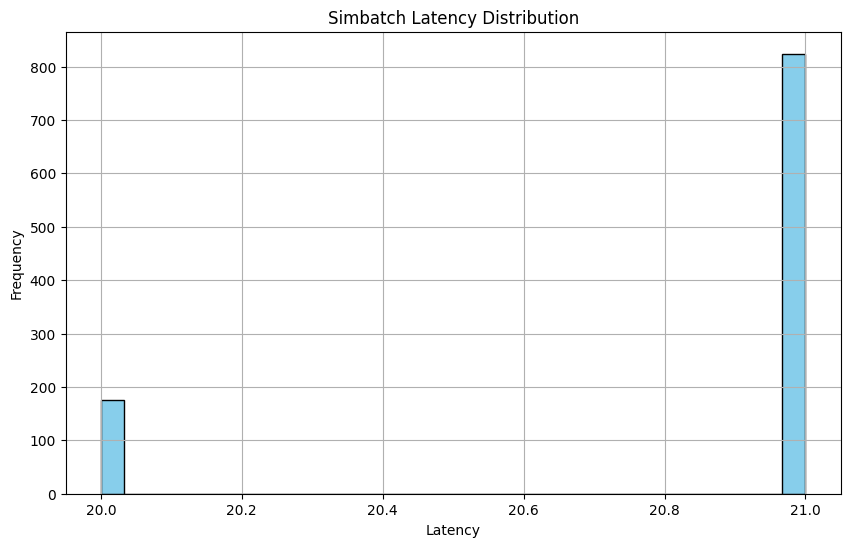

<Figure size 640x480 with 0 Axes>

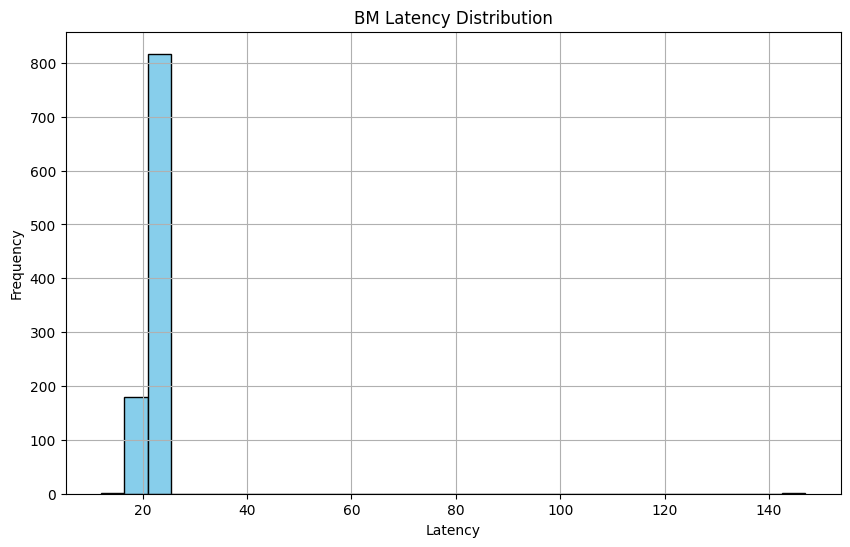

<Figure size 640x480 with 0 Axes>

In [174]:
# Single run test, it executes the entire process and return a DataFrame (df) with the errors
if singleRun:
	if runMode == "random":
		generateRandom()
	elif runMode == "existent":
		generateExistent(functionFile)
	elif runMode == "fragtester":
		generateNeuron("library", neuronUnderTest, neuronSeq, benchcore)
	else:
		print (RED + "Unknown run mode: " + runMode + STANDARD)
		exit(1)

	if runSimbatchTests:
		runSimbatch()
		errors,mse,latency=analyzeSimbatch()
		dfbsim=loadBsimRun(mse,latency)

	if runBmsimTests:
		runBMsim()
		errors,mse,latency=analyzeBMsim()
		dfbm=loadBMsimRun(mse,latency)
	
	# runHLSsim()

	if showLatencyDistribution and runSimbatchTests:
		lbsimhist=latencyHistogram('simbatch_outputs.csv','bsimlatency','Simbatch Latency Distribution')

	if showLatencyDistribution and runBmsimTests:
		lbmsimhist=latencyHistogram('bmsim_outputs.csv','bmlatency','BM Latency Distribution')
	

In [175]:
dfbsim if (singleRun and runSimbatchTests) else None

,bsimoccurrences,bsimerror,bsimlatency
addargrealnumreal,1,1.041503e-13,20.824


In [176]:
dfbm if (singleRun and runBmsimTests) else None

,bmoccurrences,bmerror,bmlatency
addargrealnumreal,1,5.836681e-13,21.45


In [177]:
lbsimhist if (singleRun and runSimbatchTests) else None

<Figure size 640x480 with 0 Axes>

In [178]:
lbmsimhist if (singleRun and runBmsimTests) else None

<Figure size 640x480 with 0 Axes>

/tmp/ipykernel_20065/2503819030.py:72: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[0, 1].boxplot([bsimData, bmsimData], labels=['Simbatch', 'BMsim'])


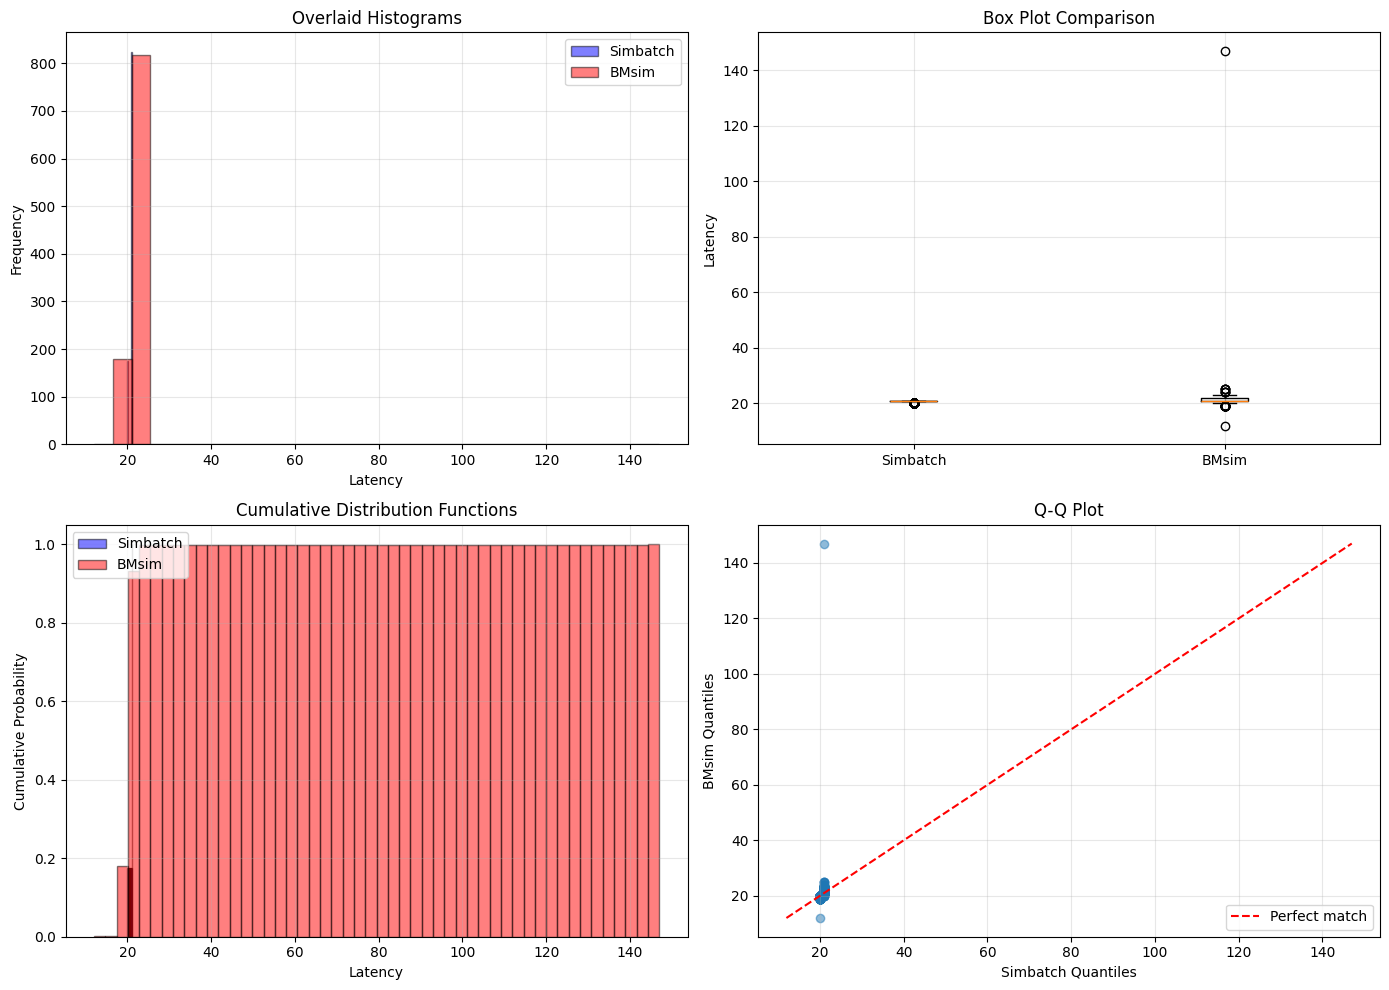

LATENCY DISTRIBUTION COMPARISON

Simbatch Statistics:
  Mean: 20.8248
  Median: 21.0000
  Std Dev: 0.3803
  Range: [20.0000, 21.0000]

BMsim Statistics:
  Mean: 21.4494
  Median: 21.0000
  Std Dev: 4.1023
  Range: [12.0000, 147.0000]

Statistical Tests:
  Kolmogorov-Smirnov Test:
    Statistic: 0.4755
    P-value: 1.5618e-102
    Distributions are DIFFERENT (α=0.05)

  Mann-Whitney U Test:
    Statistic: 309885.0000
    P-value: 2.6392e-61
    Medians are DIFFERENT (α=0.05)

  Wasserstein Distance: 0.7327
    (Lower is better, 0 = identical distributions)


{'bsim_stats': {'mean': np.float64(20.824824824824823),
  'median': np.float64(21.0),
  'std': np.float64(0.38030725941990556),
  'min': np.int64(20),
  'max': np.int64(21),
  'q25': np.float64(21.0),
  'q75': np.float64(21.0)},
 'bmsim_stats': {'mean': np.float64(21.44944944944945),
  'median': np.float64(21.0),
  'std': np.float64(4.10229873449158),
  'min': np.int64(12),
  'max': np.int64(147),
  'q25': np.float64(21.0),
  'q75': np.float64(22.0)},
 'ks_test': {'statistic': np.float64(0.4754754754754755),
  'p_value': np.float64(1.561781651914961e-102),
  'significant': np.True_},
 'mann_whitney': {'statistic': np.float64(309885.0),
  'p_value': np.float64(2.6391557317357983e-61),
  'significant': np.True_},
 'wasserstein_distance': np.float64(0.7327327327327301)}

In [179]:
# Extract latency columns for distribution comparison
if singleRun and runSimbatchTests and runBmsimTests and showLatencyDistribution:
	bsimDataDF=pd.read_csv('simbatch_outputs.csv')
	bmsimDataDF=pd.read_csv('bmsim_outputs.csv')
	# Extract just the latency column (last column)
	bsimData = bsimDataDF.iloc[:, -1]
	bmsimData = bmsimDataDF.iloc[:, -1]
	comparison_results = compareLatencyDistributions(bsimData, bmsimData)
	
comparison_results if (singleRun and runSimbatchTests and runBmsimTests and showLatencyDistribution) else None

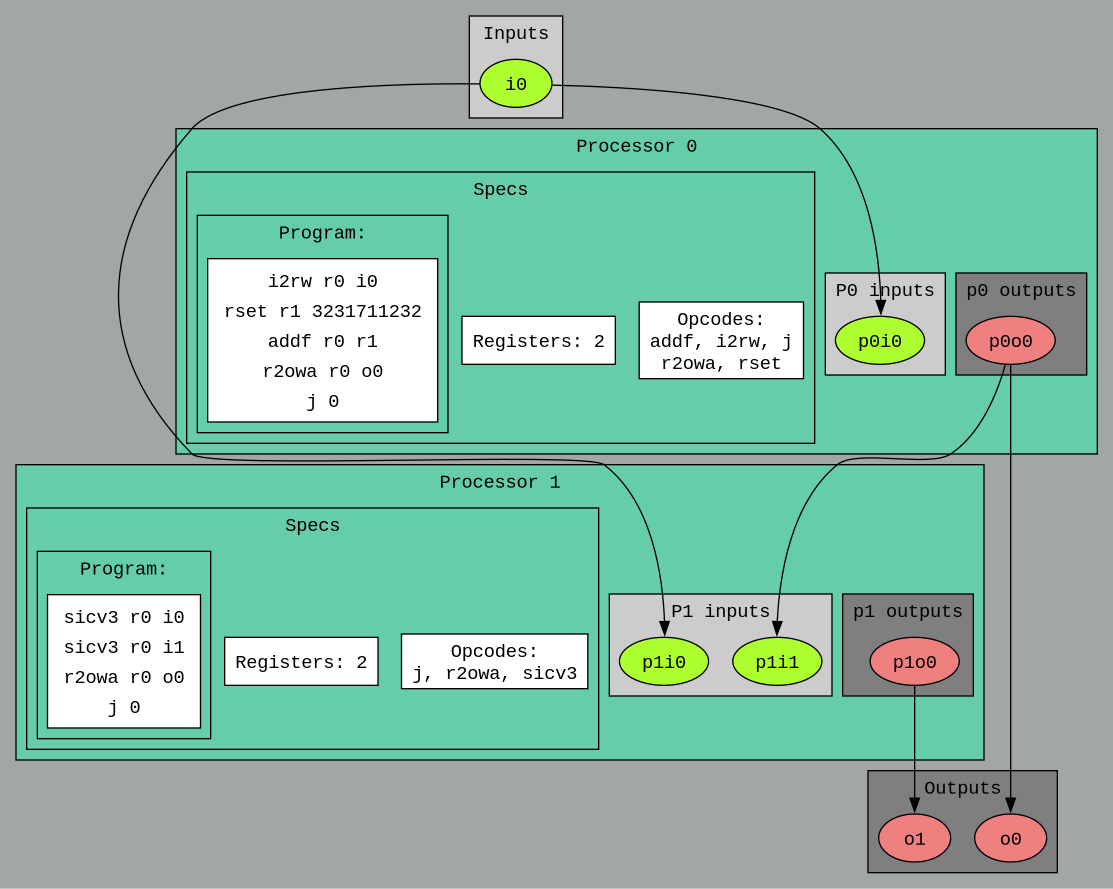

In [180]:
display.Image("bondmachine.png") if singleRun else None

In [181]:
# Load the historical global statistics and patch it with the new data (df) with the simbatch results
if singleRunPatch and runSimbatchTests:
	gs=loadGlobalStats()
	gs=PatchBsimGlobalStats(gs, dfbsim)
	gs

In [182]:
# Load the historical global statistics and patch it with the new data (df) with the bmsim results
if singleRunPatch and runBmsimTests:
	gs=loadGlobalStats()
	gs=PatchBMsimGlobalStats(gs, dfbm)
	gs

In [183]:
gs if singleRunPatch else None

In [184]:
if fullRun:
	# Iterate al the neurons in the library and test them singly, patching the global statistics
	gs=loadGlobalStats()

	for neuronFile in os.listdir("library"):
		if not neuronFile.endswith(".basm"):
			continue
		neuron = neuronFile.split(".")[0]
		# generateRandom()
		# generateExistent()

		if debug:
			print("Evaluating neuron: "+neuron)

		# Simbatch tests
		if runSimbatchTests and not(any(gs.index.str.startswith(neuron)) and gs.loc[gs.index.str.startswith(neuron), 'bsimoccurrences'].max() > 0):
			seq=getNeuronSeq("library", neuron)
			if seq!="0":
				for i in range(0, int(seq)):
					if generateNeuron("library", neuron, str(i), benchcore):
						runSimbatch()
						errors,mse,latency=analyzeSimbatch()
						df=loadBsimRun(mse,latency)
						gs=PatchBsimGlobalStats(gs, df)
					else:
						print(f"{RED}Error generating neuron {neuron} with sequence {seq}{STANDARD}")
			else:
				placeHolderNeuron("library", neuron)

				df=loadBsimRun(0.0,False)
				gs=PatchBsimGlobalStats(gs, df)
		else:
			if debug:
				print(f"{CYAN}Skipping neuron {neuron} for Simbatch tests{STANDARD}")

			# BMsim tests

		# BMsim tests
		if runBmsimTests and not(any(gs.index.str.startswith(neuron)) and gs.loc[gs.index.str.startswith(neuron), 'bmoccurrences'].max() > 0):
			seq=getNeuronSeq("library", neuron)
			if seq!="0":
				for i in range(0, int(seq)):
					if generateNeuron("library", neuron, str(i), benchcore):
						runBMsim()
						errors,mse,latency=analyzeBMsim()
						df=loadBMsimRun(mse,latency)
						gs=PatchBMsimGlobalStats(gs, df)
					else:
						print(f"{RED}Error generating neuron {neuron} with sequence {seq}{STANDARD}")
			else:
				placeHolderNeuron("library", neuron)

				df=loadBMsimRun(0.0,False)
				gs=PatchBMsimGlobalStats(gs, df)
		else:
			if debug:
				print(f"{CYAN}Skipping neuron {neuron} for BMsim tests{STANDARD}")

	gs.style.format('{:.10f}', subset=['bsimerror'])
	gs.style.format('{:.10f}', subset=['bmerror'])


In [185]:
gs.style.apply(lambda x: x.map(highlightDone), axis=None, subset=['bsimoccurrences', 'bmoccurrences']) if fullRun else None